In [1]:
import dynamic_properties as dynprop
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from eeg_recording import SingleSubjectRecording

plt.style.use("default_light")

In [2]:
def get_random_gaussian_data(n_channels, length, sampling_rate, seed=None):
    """
    Get Gaussian data of length with n_channels. Data are sampled from multivariate
    normal distribution with random mean in N(0, 1) and random covariance computed as
    cov = A dot A' with A random matrix with elements from N(0, 1).
    """
    np.random.seed(seed)
    random_cov = np.random.normal(0.0, 1.0, size=(n_channels, n_channels))
    data = pd.DataFrame(
        np.random.multivariate_normal(
            # mean=np.random.normal(0.0, 1.0, size=n_channels),
            mean=[0.0]*n_channels,
            cov=np.dot(random_cov, random_cov.transpose()),
            size=(int(length * sampling_rate)),
        ),
        columns=[f"chan {i}" for i in range(n_channels)],
        index=np.arange(0, length, 1 / sampling_rate),
    )

    return data

In [3]:
SAMPLING_RATE = 250.0  # Hz
LENGTH = 10.0  # seconds
N_CHANNELS = 2

data = get_random_gaussian_data(N_CHANNELS, LENGTH, SAMPLING_RATE, seed=43)
info = mne.create_info(
    ch_names=list(data.columns), ch_types=["eeg"] * N_CHANNELS, sfreq=SAMPLING_RATE
)
mne_data = mne.io.RawArray(data.values.T, info)

recording = SingleSubjectRecording(subject_id="IID", data=mne_data)

Creating RawArray with float64 data, n_channels=2, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.


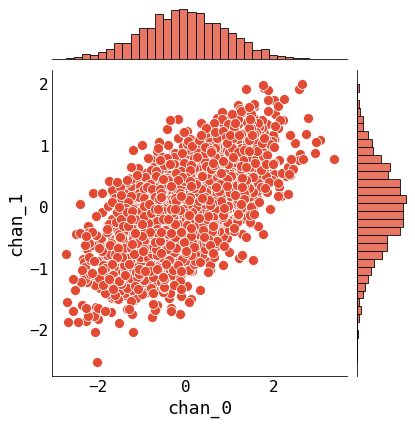

In [4]:
sns.jointplot(data=data, x="chan_0", y="chan_1")

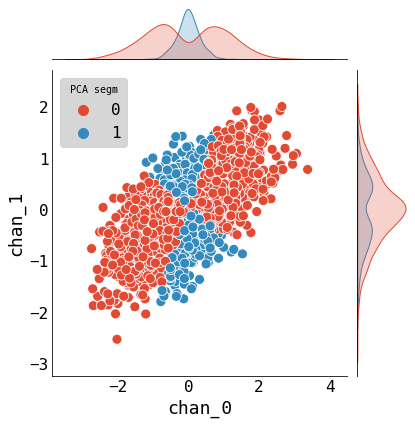

In [5]:
all_stats = pd.DataFrame()
dyn_stats = pd.DataFrame()
maps = []

recording.run_latent_pca(2)
data["PCA segm"] = recording.latent_segmentation

maps.append(
    xr.DataArray(
        recording.latent_maps,
        dims=["latent map", "channels"],
        coords={
            "latent map": ["A", "B"],
            "channels": [f"chan_{i}" for i in range(N_CHANNELS)],
        },
    )
    .assign_coords({"algorithm": "PCA"})
    .expand_dims(["algorithm"])
)

sns.jointplot(data=data, x="chan_0", y="chan_1", hue="PCA segm")

recording.compute_segmentation_stats()
df = recording.get_stats_pandas().copy()
df["algorithm"] = "PCA"
all_stats = pd.concat([all_stats, df], axis=0)


dyn_stats.loc["PCA", "mixing time"] = dynprop.mixing_time(
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2)
)
dyn_stats.loc["PCA", "entropy"] = dynprop.H_1(
    recording.latent_segmentation, 2, log2=False
)
dyn_stats.loc["PCA", "max entropy"] = dynprop.max_entropy(2, log2=False)
dyn_stats.loc["PCA", "entropy rate"] = dynprop.excess_entropy_rate(
    recording.latent_segmentation, 2, kmax=6, log2=False
)[0]
dyn_stats.loc["PCA", "MC entropy rate"] = dynprop.markov_chain_entropy_rate(
    dynprop.empirical_distribution(recording.latent_segmentation, 2),
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2),
)
aif1 = dynprop.lagged_mutual_information(
    recording.latent_segmentation, 2, max_lag=100, log2=False, pbar=False
)
dyn_stats.loc["PCA", "AIF 1st peak"] = dynprop.find_1st_aif_peak(aif1, SAMPLING_RATE)[1]

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


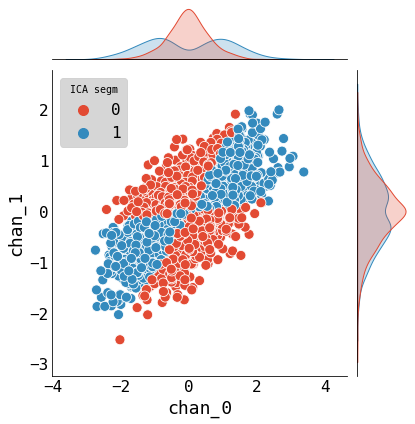

In [6]:
recording.run_latent_ica(2)
data["ICA segm"] = recording.latent_segmentation

maps.append(
    xr.DataArray(
        recording.latent_maps,
        dims=["latent map", "channels"],
        coords={
            "latent map": ["A", "B"],
            "channels": [f"chan_{i}" for i in range(N_CHANNELS)],
        },
    )
    .assign_coords({"algorithm": "ICA"})
    .expand_dims(["algorithm"])
)

sns.jointplot(data=data, x="chan_0", y="chan_1", hue="ICA segm")

recording.compute_segmentation_stats()
df = recording.get_stats_pandas().copy()
df["algorithm"] = "ICA"
all_stats = pd.concat([all_stats, df], axis=0)


dyn_stats.loc["ICA", "mixing time"] = dynprop.mixing_time(
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2)
)
dyn_stats.loc["ICA", "entropy"] = dynprop.H_1(
    recording.latent_segmentation, 2, log2=False
)
dyn_stats.loc["ICA", "max entropy"] = dynprop.max_entropy(2, log2=False)
dyn_stats.loc["ICA", "entropy rate"] = dynprop.excess_entropy_rate(
    recording.latent_segmentation, 2, kmax=6, log2=False
)[0]
dyn_stats.loc["ICA", "MC entropy rate"] = dynprop.markov_chain_entropy_rate(
    dynprop.empirical_distribution(recording.latent_segmentation, 2),
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2),
)
aif1 = dynprop.lagged_mutual_information(
    recording.latent_segmentation, 2, max_lag=100, log2=False, pbar=False
)
dyn_stats.loc["ICA", "AIF 1st peak"] = dynprop.find_1st_aif_peak(aif1, SAMPLING_RATE)[1]

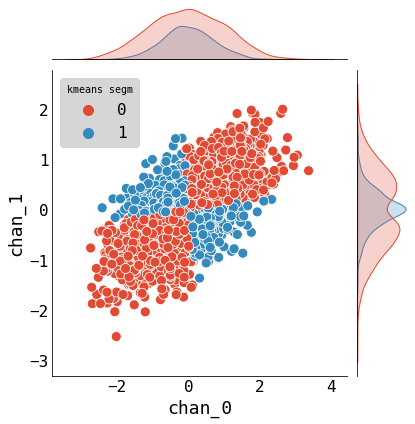

In [7]:
recording.run_latent_kmeans(2)
data["kmeans segm"] = recording.latent_segmentation

maps.append(
    xr.DataArray(
        recording.latent_maps,
        dims=["latent map", "channels"],
        coords={
            "latent map": ["A", "B"],
            "channels": [f"chan_{i}" for i in range(N_CHANNELS)],
        },
    )
    .assign_coords({"algorithm": "kmeans"})
    .expand_dims(["algorithm"])
)

sns.jointplot(data=data, x="chan_0", y="chan_1", hue="kmeans segm")

recording.compute_segmentation_stats()
df = recording.get_stats_pandas().copy()
df["algorithm"] = "kmeans"
all_stats = pd.concat([all_stats, df], axis=0)


dyn_stats.loc["kmeans", "mixing time"] = dynprop.mixing_time(
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2)
)
dyn_stats.loc["kmeans", "entropy"] = dynprop.H_1(
    recording.latent_segmentation, 2, log2=False
)
dyn_stats.loc["kmeans", "max entropy"] = dynprop.max_entropy(2, log2=False)
dyn_stats.loc["kmeans", "entropy rate"] = dynprop.excess_entropy_rate(
    recording.latent_segmentation, 2, kmax=6, log2=False
)[0]
dyn_stats.loc["kmeans", "MC entropy rate"] = dynprop.markov_chain_entropy_rate(
    dynprop.empirical_distribution(recording.latent_segmentation, 2),
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2),
)
aif1 = dynprop.lagged_mutual_information(
    recording.latent_segmentation, 2, max_lag=100, log2=False, pbar=False
)
dyn_stats.loc["kmeans", "AIF 1st peak"] = dynprop.find_1st_aif_peak(
    aif1, SAMPLING_RATE
)[1]

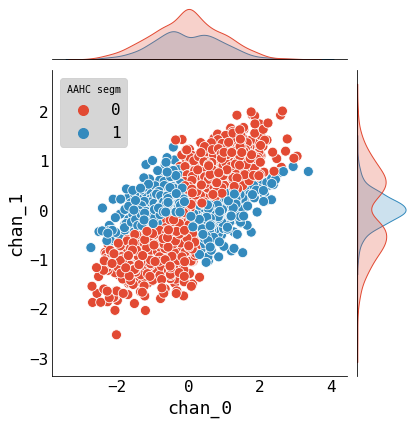

In [8]:
recording.run_latent_aahc(2)
data["AAHC segm"] = recording.latent_segmentation

maps.append(
    xr.DataArray(
        recording.latent_maps,
        dims=["latent map", "channels"],
        coords={
            "latent map": ["A", "B"],
            "channels": [f"chan_{i}" for i in range(N_CHANNELS)],
        },
    )
    .assign_coords({"algorithm": "AAHC"})
    .expand_dims(["algorithm"])
)

sns.jointplot(data=data, x="chan_0", y="chan_1", hue="AAHC segm")

recording.compute_segmentation_stats()
df = recording.get_stats_pandas().copy()
df["algorithm"] = "AAHC"
all_stats = pd.concat([all_stats, df], axis=0)


dyn_stats.loc["AAHC", "mixing time"] = dynprop.mixing_time(
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2)
)
dyn_stats.loc["AAHC", "entropy"] = dynprop.H_1(
    recording.latent_segmentation, 2, log2=False
)
dyn_stats.loc["AAHC", "max entropy"] = dynprop.max_entropy(2, log2=False)
dyn_stats.loc["AAHC", "entropy rate"] = dynprop.excess_entropy_rate(
    recording.latent_segmentation, 2, kmax=6, log2=False
)[0]
dyn_stats.loc["AAHC", "MC entropy rate"] = dynprop.markov_chain_entropy_rate(
    dynprop.empirical_distribution(recording.latent_segmentation, 2),
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2),
)
aif1 = dynprop.lagged_mutual_information(
    recording.latent_segmentation, 2, max_lag=100, log2=False, pbar=False
)
dyn_stats.loc["AAHC", "AIF 1st peak"] = dynprop.find_1st_aif_peak(aif1, SAMPLING_RATE)[
    1
]

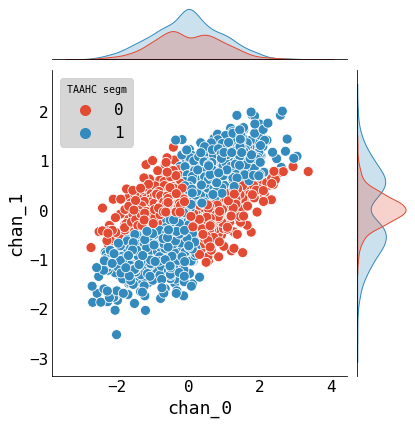

In [9]:
recording.run_latent_taahc(2)
data["TAAHC segm"] = recording.latent_segmentation

maps.append(
    xr.DataArray(
        recording.latent_maps,
        dims=["latent map", "channels"],
        coords={
            "latent map": ["A", "B"],
            "channels": [f"chan_{i}" for i in range(N_CHANNELS)],
        },
    )
    .assign_coords({"algorithm": "TAAHC"})
    .expand_dims(["algorithm"])
)

sns.jointplot(data=data, x="chan_0", y="chan_1", hue="TAAHC segm")

recording.compute_segmentation_stats()
df = recording.get_stats_pandas().copy()
df["algorithm"] = "TAAHC"
all_stats = pd.concat([all_stats, df], axis=0)


dyn_stats.loc["TAAHC", "mixing time"] = dynprop.mixing_time(
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2)
)
dyn_stats.loc["TAAHC", "entropy"] = dynprop.H_1(
    recording.latent_segmentation, 2, log2=False
)
dyn_stats.loc["TAAHC", "max entropy"] = dynprop.max_entropy(2, log2=False)
dyn_stats.loc["TAAHC", "entropy rate"] = dynprop.excess_entropy_rate(
    recording.latent_segmentation, 2, kmax=6, log2=False
)[0]
dyn_stats.loc["TAAHC", "MC entropy rate"] = dynprop.markov_chain_entropy_rate(
    dynprop.empirical_distribution(recording.latent_segmentation, 2),
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2),
)
aif1 = dynprop.lagged_mutual_information(
    recording.latent_segmentation, 2, max_lag=100, log2=False, pbar=False
)
dyn_stats.loc["TAAHC", "AIF 1st peak"] = dynprop.find_1st_aif_peak(aif1, SAMPLING_RATE)[
    1
]

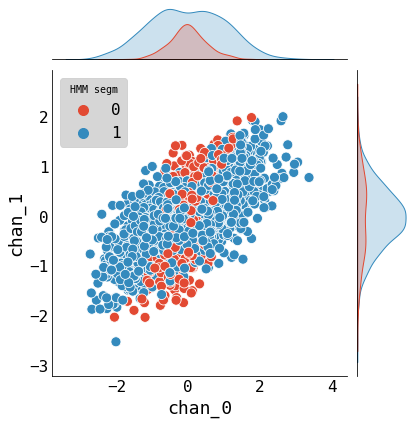

In [10]:
recording.run_latent_hmm(2)
data["HMM segm"] = recording.latent_segmentation

maps.append(
    xr.DataArray(
        recording.latent_maps,
        dims=["latent map", "channels"],
        coords={
            "latent map": ["A", "B"],
            "channels": [f"chan_{i}" for i in range(N_CHANNELS)],
        },
    )
    .assign_coords({"algorithm": "HMM"})
    .expand_dims(["algorithm"])
)

sns.jointplot(data=data, x="chan_0", y="chan_1", hue="HMM segm")

recording.compute_segmentation_stats()
df = recording.get_stats_pandas().copy()
df["algorithm"] = "HMM"
all_stats = pd.concat([all_stats, df], axis=0)


dyn_stats.loc["HMM", "mixing time"] = dynprop.mixing_time(
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2)
)
dyn_stats.loc["HMM", "entropy"] = dynprop.H_1(
    recording.latent_segmentation, 2, log2=False
)
dyn_stats.loc["HMM", "max entropy"] = dynprop.max_entropy(2, log2=False)
dyn_stats.loc["HMM", "entropy rate"] = dynprop.excess_entropy_rate(
    recording.latent_segmentation, 2, kmax=6, log2=False
)[0]
dyn_stats.loc["HMM", "MC entropy rate"] = dynprop.markov_chain_entropy_rate(
    dynprop.empirical_distribution(recording.latent_segmentation, 2),
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2),
)
aif1 = dynprop.lagged_mutual_information(
    recording.latent_segmentation, 2, max_lag=100, log2=False, pbar=False
)
dyn_stats.loc["HMM", "AIF 1st peak"] = dynprop.find_1st_aif_peak(aif1, SAMPLING_RATE)[1]

In [16]:
data[data.columns[2:]].rcorr("spearman", padjust="fdr_by")

,PCA segm,ICA segm,kmeans segm,AAHC segm,TAAHC segm,HMM segm
PCA segm,-,***,***,*,,***
ICA segm,-0.599,-,***,***,***,***
kmeans segm,0.293,-0.634,-,***,***,*
AAHC segm,0.05,-0.325,0.716,-,***,***
TAAHC segm,-0.034,0.303,-0.697,-0.979,-,***
HMM segm,-0.311,0.298,0.056,0.174,-0.183,-


In [12]:
all_stats

,subject_id,latent map,var_GFP,var_total,template_corr,coverage,occurrence,lifespan,transition->A,transition->B,algorithm
0,IID,A,1.0,1.0,NaN,0.7296,51.8,14.096712,0.715853,0.284147,PCA
1,IID,B,1.0,1.0,NaN,0.2704,51.8,5.220077,0.766272,0.233728,PCA
0,IID,A,1.0,1.0,NaN,0.5080,63.7,7.974882,0.498425,0.501575,ICA
1,IID,B,1.0,1.0,NaN,0.4920,63.7,7.723270,0.518308,0.481692,ICA
0,IID,A,1.0,1.0,NaN,0.6988,52.6,13.295238,0.698740,0.301260,kmeans
1,IID,B,1.0,1.0,NaN,0.3012,52.6,5.726236,0.698539,0.301461,kmeans
0,IID,A,1.0,1.0,NaN,0.6240,59.8,10.438861,0.616421,0.383579,AAHC
1,IID,B,1.0,1.0,NaN,0.3760,59.8,6.287625,0.636170,0.363830,AAHC
0,IID,A,1.0,1.0,NaN,0.3828,60.2,6.358804,0.370951,0.629049,TAAHC
1,IID,B,1.0,1.0,NaN,0.6172,60.2,10.256240,0.390402,0.609598,TAAHC


In [13]:
dyn_stats

,mixing time,entropy,max entropy,entropy rate,MC entropy rate,AIF 1st peak
PCA,0.952001,0.583656,0.693147,0.580741,0.840331,40.0
ICA,0.980505,0.693019,0.693147,0.690864,0.999520,44.0
kmeans,1.000201,0.611878,0.693147,0.609413,0.882899,44.0
AAHC,0.980633,0.662072,0.693147,0.659656,0.954998,44.0
TAAHC,0.980920,0.665418,0.693147,0.663140,0.959830,44.0
HMM,1.223191,0.522828,0.693147,0.505320,0.732337,36.0


In [14]:
maps = xr.concat(maps, dim="algorithm")
all_corrs = []
for alg1 in maps["algorithm"]:
    for alg2 in maps["algorithm"]:
        for map1 in maps["latent map"]:
            for map2 in maps["latent map"]:
                corrs = (
                    xr.corr(
                        maps.sel({"algorithm": alg1, "latent map": map1}),
                        maps.sel({"algorithm": alg2, "latent map": map2}),
                        dim="channels",
                    )
                    .assign_coords(
                        {"alg1": alg1, "alg2": alg2, "map1": map1, "map2": map2}
                    )
                    .expand_dims(["alg1", "alg2", "map1", "map2"])
                )
                all_corrs.append(corrs)
all_corrs = xr.combine_by_coords(all_corrs)
maps

<xarray.DataArray (algorithm: 6, latent map: 2, channels: 2)>
array([[[ 0.9550147 ,  0.29655846],
        [ 0.29655846, -0.9550147 ]],

       [[ 0.02123487, -0.03886888],
        [ 0.01743381,  0.00708897]],

       [[-0.90516115, -0.42506857],
        [ 0.96678883, -0.25557652]],

       [[ 0.95078208,  0.30986036],
        [ 0.96069412,  0.27760909]],

       [[ 0.95542801,  0.29522418],
        [ 0.94747126,  0.31984092]],

       [[-0.89441611,  0.52114659],
        [ 0.24758607, -0.14426019]]])
Coordinates:
  * latent map  (latent map) <U1 'A' 'B'
  * channels    (channels) <U6 'chan_0' 'chan_1'
  * algorithm   (algorithm) <U6 'PCA' 'ICA' 'kmeans' 'AAHC' 'TAAHC' 'HMM'